In [2]:
# ============================================================================
# CELDA 1: SETUP Y CARGA DE DATOS (CORREGIDA V3 - 52 COMUNAS)
# ============================================================================
%run ./00_template.py

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os

# Definir capa de comunas
LAYER_COMUNAS = "comunas_rm_censo" 

# Rutas
PARQ = OUTPUTS_DIR / "comunas_accessibility_otp.parquet"
LONG = OUTPUTS_DIR / "accesibilidad_otp_final.csv" # Usamos el final

print(" Iniciando Síntesis (Notebook 05)")

# --- 1. Cargar Geometría (La Verdad Oficial: 52 Comunas) ---
comunas = gpd.read_file(RUTA_GPKG, layer=LAYER_COMUNAS).copy()
if "CUT_COM" in comunas.columns and "cod_comuna" not in comunas.columns:
    comunas = comunas.rename(columns={"CUT_COM": "cod_comuna"})
comunas["cod_comuna"] = comunas["cod_comuna"].astype(str)

print(f"Base de mapas cargada: {len(comunas)} comunas (deben ser 52)")

# --- 2. Cargar y Procesar CSV ---
# Siempre reconstruimos para asegurar el cruce correcto
print("Procesando datos de accesibilidad...")

if not LONG.exists():
    # Fallback
    LONG = OUTPUTS_DIR / "acc_long_partial.csv"

if not LONG.exists():
    raise FileNotFoundError(" No se encuentra ningún CSV de datos.")

acc_long = pd.read_csv(LONG)

# Normalización de nombres de columnas
if "minutos" in acc_long.columns: acc_long = acc_long.rename(columns={"minutos": "t_min_otp"})
if "time" in acc_long.columns: acc_long = acc_long.rename(columns={"time": "t_min_otp"})
if "cat" in acc_long.columns: acc_long = acc_long.rename(columns={"cat": "categoria"})
if "cod" in acc_long.columns: acc_long = acc_long.rename(columns={"cod": "cod_comuna"})

# Asegurar numérico
acc_long["t_min_otp"] = pd.to_numeric(acc_long["t_min_otp"], errors="coerce")

# Pivotar
acc_pivot = acc_long.pivot_table(
    index=["cod_comuna"], 
    columns="categoria",
    values="t_min_otp",
    aggfunc="min"
).reset_index()

acc_pivot["cod_comuna"] = acc_pivot["cod_comuna"].astype(str)

# --- 3. EL CRUCE MAESTRO (FIX: Left Join usando Comunas como base) ---
# Usamos 'comunas' a la izquierda para mantener las 52 filas, aunque no tengan datos.
base_comunas = comunas[["cod_comuna", "COMUNA"]].copy()
acc = base_comunas.merge(acc_pivot, on="cod_comuna", how="left")

acc = acc.rename(columns={"COMUNA": "comuna"})

# Guardar
acc.to_parquet(PARQ, index=False)

# Definir Features
id_cols = {"cod_comuna", "comuna", "cluster", "geometry"} 
FEATURES = [c for c in acc.columns if c not in id_cols]

print(f" Dimensiones Finales: {acc.shape}")
print(f"   (Debería ser 52 filas. Las faltantes tendrán NaN y serán imputadas después)")
print(f" Servicios detectados ({len(FEATURES)}): {FEATURES}")

if len(acc) != 52:
    print(" ADVERTENCIA: Aún no tenemos 52 filas. Revisa el GeoPackage.")

===  Template PEP1 Configurado Exitosamente ===
 Base Dir       : /home/jovyan
 GeoDatabase    :  Encontrada
 Censo CSV      :  Encontrado
 Iniciando Síntesis (Notebook 05)
Base de mapas cargada: 52 comunas (deben ser 52)
Procesando datos de accesibilidad...
 Dimensiones Finales: (52, 21)
   (Debería ser 52 filas. Las faltantes tendrán NaN y serán imputadas después)
 Servicios detectados (19): ['almacenes_barrio', 'areas_verdes', 'bancos', 'bencineras', 'bomberos', 'carabineros', 'deporte_infra', 'educacion_escolar', 'educacion_superior', 'estadios', 'ferias_libres', 'iglesias', 'malls', 'metro_tren', 'micro', 'municipios', 'museos', 'salud', 'supermercados']


In [3]:
# ============================================================================
# CELDA 2, 3 y 4: CLUSTERING Y CÁLCULO DE DESIERTOS
# ============================================================================

# --- 1. Preprocesamiento ---
X = acc[FEATURES].copy()

# Imputación: Si OTP falló (NaN), asumimos que es porque está muy lejos.
# Rellenamos con el percentil 90 (tiempo alto = "castigo")
for col in FEATURES:
    p90 = np.nanpercentile(X[col].values, 90)
    X[col] = X[col].fillna(p90)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 2. Clustering (Usamos K=4 basado en análisis previo) ---
k_opt = 4 
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)

df = acc.copy()
df["cluster"] = kmeans.fit_predict(X_scaled)

# --- 3. Detección de Desiertos ---
THRESH_MIN = 30.0  # Umbral crítico: más de 30 min se considera desierto

tabla = df.copy()

# Creamos flags binarios (1 = Es desierto, 0 = No)
for col in FEATURES:
    # Es desierto si es NaN (sin cobertura) o si el tiempo > umbral
    tabla[f"es_desierto_{col}"] = (tabla[col].isna()) | (tabla[col] > THRESH_MIN)

# Contamos cuántos servicios fallan por comuna
bin_cols = [c for c in tabla.columns if c.startswith("es_desierto_")]
tabla["n_servicios_en_desierto"] = tabla[bin_cols].sum(axis=1)
tabla["porcentaje_desierto"] = (tabla["n_servicios_en_desierto"] / len(FEATURES)) * 100

# --- 4. Estadísticas Rápidas ---
print(f"--- Resumen de Desiertos (Umbral: {THRESH_MIN} min) ---")
print(f"Promedio de servicios no accesibles por comuna: {tabla['n_servicios_en_desierto'].mean():.2f}")
print(f"Peor caso (Máximo servicios fallidos): {tabla['n_servicios_en_desierto'].max()} de {len(FEATURES)}")
print(f"Mejor caso (Mínimo servicios fallidos): {tabla['n_servicios_en_desierto'].min()}")

tabla[["cod_comuna", "comuna", "cluster", "n_servicios_en_desierto"]].head()

--- Resumen de Desiertos (Umbral: 30.0 min) ---
Promedio de servicios no accesibles por comuna: 9.56
Peor caso (Máximo servicios fallidos): 19 de 19
Mejor caso (Mínimo servicios fallidos): 1


,cod_comuna,comuna,cluster,n_servicios_en_desierto
0,13130,San Miguel,1,3
1,13118,Macul,3,3
2,13119,Maipú,2,10
3,13123,Providencia,3,3
4,13131,San Ramón,1,4


 Top 10 Comunas con mayor déficit de accesibilidad:


,cod_comuna,comuna,cluster,n_servicios_en_desierto
20,13124,Pudahuel,2,19
11,13202,Pirque,2,19
39,13115,Lo Barnechea,2,19
32,13503,Curacaví,2,19
45,13303,Tiltil,2,19
41,13203,San José de Maipo,2,19
16,13301,Colina,2,19
40,13502,Alhué,2,19
7,13601,Talagante,2,19
50,13505,San Pedro,2,19


  Imagen guardada: sintesis_mapa_indice_desiertos.png


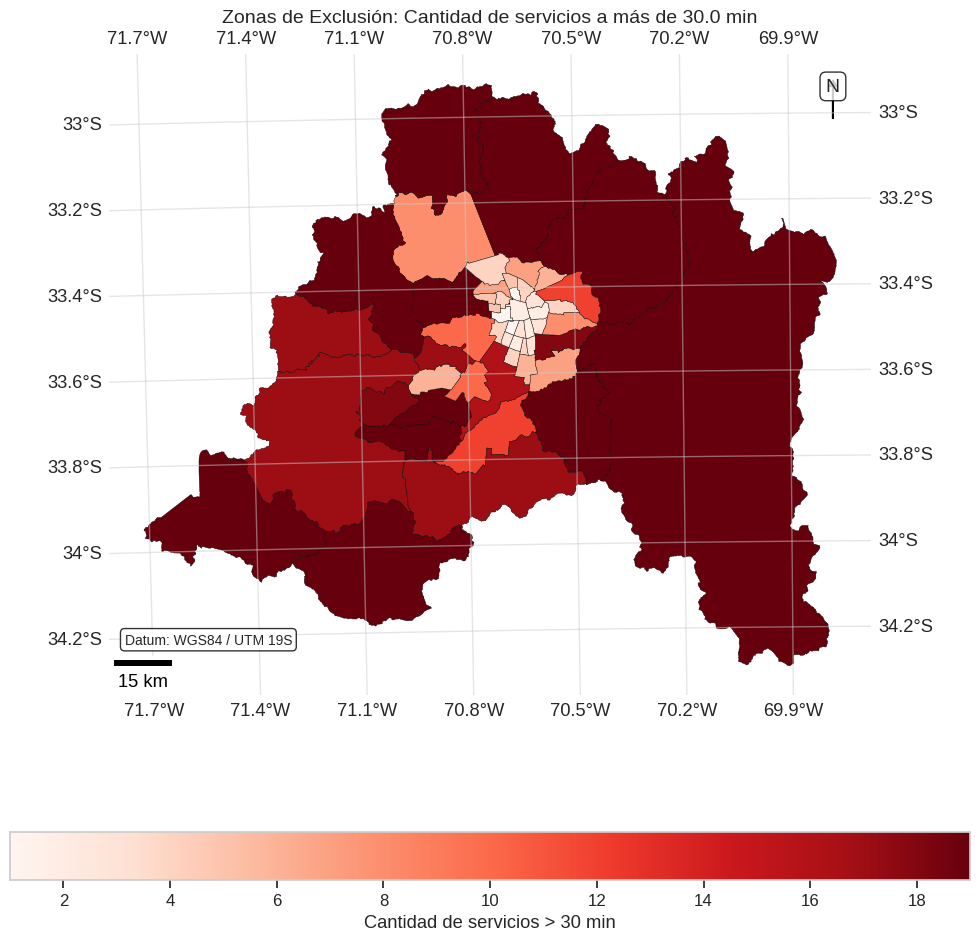

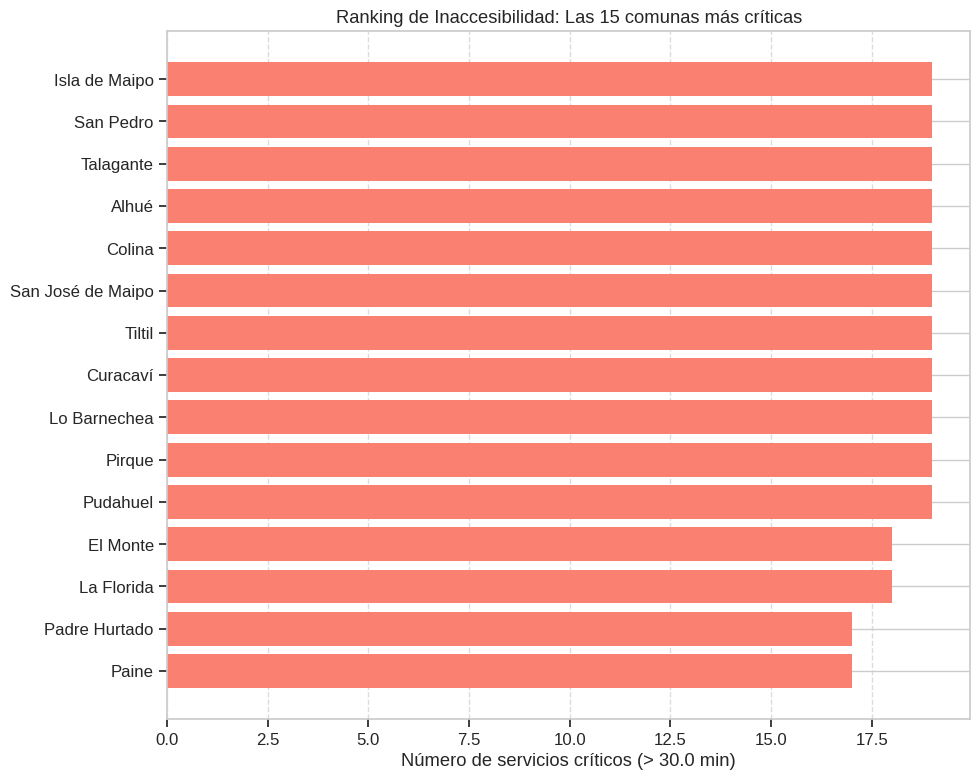

In [4]:
# ============================================================================
# CELDA 5, 6 y 7: VISUALIZACIÓN
# ============================================================================

# 1. Ranking de las peores comunas
top_desiertos = tabla[["cod_comuna", "comuna", "cluster", "n_servicios_en_desierto"]].copy()
top_desiertos = top_desiertos.sort_values("n_servicios_en_desierto", ascending=False)

print(" Top 10 Comunas con mayor déficit de accesibilidad:")
display(top_desiertos.head(10))

# 2. Mapa de "Intensidad de Desierto"
comunas_map = comunas.merge(
    tabla[["cod_comuna", "n_servicios_en_desierto", "cluster"]],
    on="cod_comuna",
    how="left"
)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.UTM(19, southern_hemisphere=True))
comunas_map.plot(
    column="n_servicios_en_desierto",
    ax=ax,
    legend=True,
    legend_kwds={'label': "Cantidad de servicios > 30 min", 'orientation': "horizontal"},
    cmap="Reds",     # Rojo intenso = Muchos servicios inaccesibles
    edgecolor="black",
    linewidth=0.3,
    missing_kwds={'color': 'lightgrey'}, # Por si alguna comuna no cruzó
    transform=ccrs.UTM(19, southern_hemisphere=True)
)

ax.set_title(f"Zonas de Exclusión: Cantidad de servicios a más de {THRESH_MIN} min", fontsize=14)
ax.set_axis_off()
# Agregar elementos del mapa
ax.gridlines(draw_labels=True, alpha=0.5)
scalebar = ScaleBar(1, location='lower left', scale_loc='bottom', length_fraction=0.1, units='m')
ax.add_artist(scalebar)
ax.text(0.02, 0.08, 'Datum: WGS84 / UTM 19S', transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.annotate('N', xy=(0.95, 0.95), xycoords='axes fraction', fontsize=14, ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.arrow(0.95, 0.9, 0, 0.05, head_width=0.01, head_length=0.01, fc='black', ec='black', transform=ax.transAxes)
plt.tight_layout()

# Función segura para guardar (por si no está definida en template)
try:
    save_figure(fig, "sintesis_mapa_indice_desiertos")
except NameError:
    plt.savefig(OUTPUTS_DIR / "sintesis_mapa_indice_desiertos.png", dpi=300, bbox_inches='tight')

plt.show()

# 3. Gráfico de Barras
top_plot = top_desiertos.head(15).sort_values("n_servicios_en_desierto") # Top 15 para el gráfico

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(top_plot["comuna"], top_plot["n_servicios_en_desierto"], color='salmon')
ax.set_xlabel(f"Número de servicios críticos (> {THRESH_MIN} min)")
ax.set_title("Ranking de Inaccesibilidad: Las 15 comunas más críticas")
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [5]:
# ============================================================================
# CELDA 8: EXPORTACIÓN
# ============================================================================
tabla_final_path = OUTPUTS_DIR / "tabla_final_desiertos_servicios.csv"
tabla.to_csv(tabla_final_path, index=False)

print(f" Análisis completado.")
print(f" Archivo maestro guardado en: {tabla_final_path}")
print("   Contiene: Tiempos OTP + Cluster asignado + Flags de desierto")

 Análisis completado.
 Archivo maestro guardado en: /home/jovyan/outputs/tabla_final_desiertos_servicios.csv
   Contiene: Tiempos OTP + Cluster asignado + Flags de desierto
